## Land and Atm histograms and time series

####  Note: land tile is at -4.73 lat, 295.0 lon

ideas:  
max and min of each day  
mapping of utc to local solar hour by longitude  
LST (hours) = UTC hour + lon(deg E)/360*24

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# files
lnddir = '/beegfs/DATA/pritchard/gyacalis/aquaplanet/lnd/avgs/'
nslnd = xr.open_dataset(lnddir + 'ns_avg_2yr.nc')
splnd = xr.open_dataset(lnddir + 'sp_avg_2yr.nc')
nnlnd = xr.open_dataset(lnddir + 'nn_avg_2yr.nc')

atmdir = '/beegfs/DATA/pritchard/gyacalis/aquaplanet/aqua_year_concats/'
nsatm = xr.open_dataset(atmdir + 'ns_aqua_avg_1yr.nc', decode_times=False)
spatm = xr.open_dataset(atmdir + 'sp_aqua_avg_1yr.nc', decode_times=False) 
nnatm = xr.open_dataset(atmdir + 'nn_aqua_avg_1yr.nc', decode_times=False)

In [3]:
# make TOTH2OSOI for lnd files: sum all the values along the vertical axis of H2OSOI
for ds in [nslnd, splnd, nnlnd]:
    ds['TOTH2OSOI'] = ds['QSOIL']
    ds.TOTH2OSOI.attrs['units'] = 'mm3/mm3'
    ds.TOTH2OSOI.attrs['long_name'] = 'total volumetric soil water (vegetated landunits only)'
    ds.TOTH2OSOI.values = np.sum(ds.H2OSOI.values, 1)

In [4]:
def plothist(ns, sp, nn, variable, bins=50, xmin=0, xmax=None, 
             usetimeslice=False, tstart='2004-01-02', tend='2005-12-31',
             rmnonpos=False, mvnonpostominpos=False, mvnegtozero=False):

    # get the desired time slice values
    if usetimeslice:
        tslice = slice(tstart, tend)
        nsslice = ns[variable].sel(time=tslice).values.flatten()
        spslice = sp[variable].sel(time=tslice).values.flatten()
        nnslice = nn[variable].sel(time=tslice).values.flatten()
    else:
        nsslice = ns[variable].values.flatten()
        spslice = sp[variable].values.flatten()
        nnslice = nn[variable].values.flatten()

    # remove nans
    nsslice = nsslice[~np.isnan(nsslice)]
    spslice = spslice[~np.isnan(spslice)]
    nnslice = nnslice[~np.isnan(nnslice)]

    # order the arrays for plotting histograms
    hns = np.sort(nsslice)
    hsp = np.sort(spslice)
    hnn = np.sort(nnslice)

    # testing what happens if I move the (typically only NN) zero and negative 
    # values up to their next-lowest value
    def nonpositivetominpositive(a):
        a[a < 0.0] = 0.0
        a[a == 0.0] = a[a.nonzero()].min()
        return a
    if mvnonpostominpos:
        hns = nonpositivetominpositive(hns)
        hsp = nonpositivetominpositive(hsp)
        hnn = nonpositivetominpositive(hnn)

    # if want to force all negative values to be 0
    if mvnegtozero:
        hns[hns < 0.0] = 0.0
        hsp[hsp < 0.0] = 0.0
        hnn[hnn < 0.0] = 0.0

    # if want to just remove all zero or negative values
    if rmnonpos:
        hns = hns[hns > 0.0]
        hsp = hsp[hsp > 0.0]
        hnn = hnn[hnn > 0.0]

    # for calculating the best fit lines
    nsmean = hns.mean()
    spmean = hsp.mean()
    nnmean = hnn.mean()
    nsstd = hns.std()
    spstd = hsp.std()
    nnstd = hnn.std()

    # calculate the best fit lines
    nsfit = stats.norm.pdf(hns, nsmean, nsstd)
    spfit = stats.norm.pdf(hsp, spmean, spstd)
    nnfit = stats.norm.pdf(hnn, nnmean, nnstd)

    # print out good-to-know values in a nice format
    dfdict = {'mean':[nsmean, spmean, nnmean], 
              'std':[nsstd, spstd, nnstd], 
              'min':[hns.min(), hsp.min(), hnn.min()], 
              'max':[hns.max(), hsp.max(), hnn.max()],
              'datapoints':[hns.shape[0], hsp.shape[0], hnn.shape[0]]}
    dfdata = pd.DataFrame(data = dfdict, index=['nonsp', 'sp', 'nn'])
    print(dfdata)

    # attempting to make the range of the bins reasonable in cases of long trails
    binmin = min(nsmean-(3*nsstd), spmean-(3*spstd), nnmean-(3*nnstd))
    binmax = max(nsmean+(3*nsstd), spmean+(3*spstd), nnmean+(3*nnstd))
    binrange = (binmin, binmax)

    # create figure for plotting
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot()

    # set colors to use
    colormap = ('#b1ca80', '#e59800', '#d1c4df', '#ffd500', '#436c00', '#6b437a')

    # plot histograms
    ax.hist(hns, bins=bins, alpha=0.5, edgecolor='black', range=binrange, color=colormap[0], normed=True)
    ax.hist(hsp, bins=bins, alpha=0.5, edgecolor='black', range=binrange, color=colormap[1], normed=True)
    ax.hist(hnn, bins=bins, alpha=0.5, edgecolor='black', range=binrange, color=colormap[2], normed=True)

    # plot best fit lines
    ax.plot(hns, nsfit, linewidth=4, color=colormap[3])
    ax.plot(hsp, spfit, linewidth=4, color=colormap[4])
    ax.plot(hnn, nnfit, linewidth=4, color=colormap[5])

    # set the title, labels, and legend
    units = ns[variable].attrs['units']
    area = f'lat: -4.7, lon: 295'
    ax.set_title(f'Relative frequency of {variable} at {area}', fontsize='xx-large')
    ax.set_xlabel(units, fontsize='x-large')
    ax.legend(('NS', 'SP', 'NN'), fontsize='x-large')

    # set x_lims if desired
    if xmin != 0:
        if xmax is not None:
            ax.set_xlim(xmin, xmax)
        else:
            xmax = max(hns.max(), hsp.max(), hnn.max())
            ax.set_xlim(xmin, xmax)
    if xmax is not None:
        ax.set_xlim(xmin, xmax)

    # finally, show the plot
    plt.show()

In [5]:
def plotlndresample(ns, sp, nn, variable, resample, value='mean', tstart='2004-01-02', tend='2005-12-31'):
    
    # set vars
    arrs = [ns, sp, nn]
    tslice = slice(tstart, tend)
    units = ns[variable].attrs['units']
    area = f'lat: -4.7, lon: 295'
    colormap = ('#ffd500', '#436c00', '#6b437a')
    interval = {'h': 'Hourly', 'D': 'Daily', 'W': 'Weekly', 'M': 'Monthly '}
    title = f'{interval.get(resample, "Unknown interval")}{value} time series of {variable} at {area}'
    
    # create figure
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot()
    
    # plot values
    if value == 'mean':
        for i, arr in enumerate(arrs):
            arr[variable].sel(time=tslice).resample(time=resample).mean().plot(color=colormap[i], linewidth=3)
    elif value == 'max':
        for i, arr in enumerate(arrs):
            arr[variable].sel(time=tslice).resample(time=resample).max().plot(color=colormap[i], linewidth=3)
    elif value == 'min':
        for i, arr in enumerate(arrs):
            arr[variable].sel(time=tslice).resample(time=resample).min().plot(color=colormap[i], linewidth=3)
    else:
        print('Invalid arg for "value", must choose mean, max, or min; now displaying mean.')
        for i, arr in enumerate(arrs):
            arr[variable].sel(time=tslice).resample(time=resample).mean().plot(color=colormap[i], linewidth=3)
    
    # set figure properties
    #ax.set_facecolor('xkcd:pale blue')
    ax.set_title(title, fontsize='xx-large')
    ax.set_xlabel('time', fontsize='x-large')
    ax.set_ylabel(units, fontsize='x-large')
    ax.legend(('NS', 'SP', 'NN'), fontsize='x-large')
    
    # display the plot
    plt.show()
    
    return

In [8]:
def plottimeseries(ns, sp, nn, variable, groupby=None, usetimeslice=False, tstart='2004-01-02', tend='2004-12-31'):

    # get slices
    if usetimeslice:
        tslice = slice(tstart, tend)
        times = ns.time.sel(time=tslice).values.flatten()
        nsvals = ns[variable].sel(time=tslice).values.flatten()
        spvals = sp[variable].sel(time=tslice).values.flatten()
        nnvals = nn[variable].sel(time=tslice).values.flatten()
    else:
        times = ns.time.values.flatten()
        nsvals = ns[variable].values.flatten()
        spvals = sp[variable].values.flatten()
        nnvals = nn[variable].values.flatten()

    # remove nan
    nsvals[np.isnan(nsvals)] = 0
    spvals[np.isnan(spvals)] = 0
    nnvals[np.isnan(nnvals)] = 0
    
    # if want to group by a certain time -- basically plotresample, but works for atm files
    if groupby in ['D', 'W', 'M']:
        data = {f'ns {variable}': ns[variable].values.flatten(), 
                f'sp {variable}': sp[variable].values.flatten(),
                f'nn {variable}': nn[variable].values.flatten()}
        group = ''
        if groupby == 'D':
            group = 'Daily'
            data[group] = ns.time.values // 1
        elif groupby == 'W':
            group = 'Weekly'
            data[group] = ns.time.values // 7
        elif groupby == 'M':
            group = 'Monthly'
            data[group] = ns.time.values // 30
        columns = [f'ns {variable}', f'sp {variable}', f'nn {variable}', group]
        units = ns[variable].attrs['units']
        area = f'lat: -4.7, lon: 295'
        title =  f'{group} time series of {variable} at {area}  ({units})'
        colormap = ('#ffd500', '#436c00', '#6b437a')
        pd.DataFrame(data, columns=columns).groupby(group).mean().plot(
            figsize=(15,5), title=title, linewidth=3, color=colormap)
        return

    # create figure for plotting
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot()

    # set colors to use
    colormap = ('#b1ca80', '#e59800', '#d1c4df', '#ffd500', '#436c00', '#6b437a')

    # plot best fit lines
    ax.plot(times, nsvals, linewidth=2, color=colormap[3])
    ax.plot(times, spvals, linewidth=2, color=colormap[4])
    ax.plot(times, nnvals, linewidth=2, color=colormap[5])

    # set the title, labels, and legend
    units = ns[variable].attrs['units']
    area = f'lat: -4.7, lon: 295'
    ax.set_title(f'Time series of {variable} at {area}')
    ax.set_ylabel(units, fontsize='x-large')
    ax.legend(('NS', 'SP', 'NN'), fontsize='x-large')

    # finally, show the plot
    plt.show()
    
    return

####  Atm hist and time series

       datapoints         max        mean       min         std
nonsp        9516  830.525391  374.817352  0.479446  247.190933
sp           9882  889.639526  393.076294  0.384124  268.204712
nn          15275  879.301636  259.217957  0.000008  292.387421


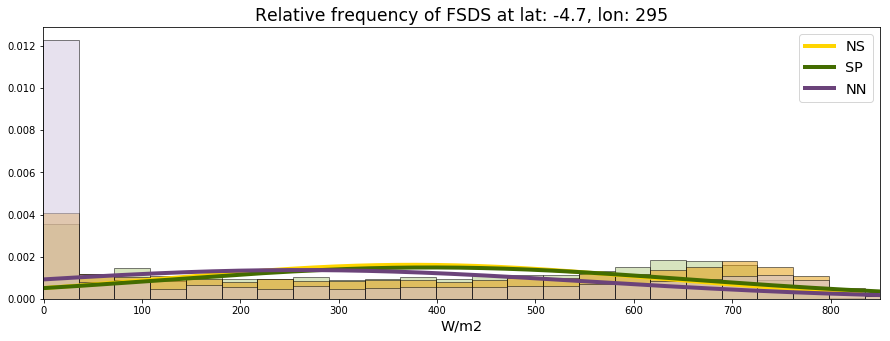

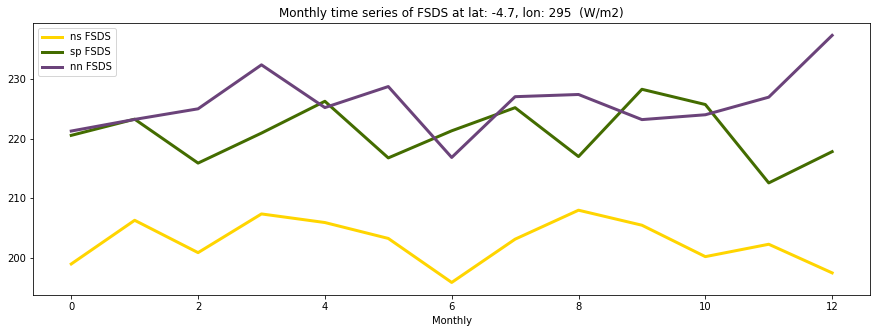

In [9]:
plothist(nsatm, spatm, nnatm, 'FSDS', rmnonpos=True, xmin=-1, xmax=850)
plottimeseries(nsatm, spatm, nnatm, 'FSDS', groupby='M')

       datapoints           max          mean           min           std
nonsp       17569  2.397235e-07  5.528647e-08  3.024843e-09  2.173526e-08
sp          17569  4.073879e-07  4.919200e-08  0.000000e+00  4.268674e-08
nn          17569  2.649645e-07  5.081773e-08  0.000000e+00  3.907952e-08


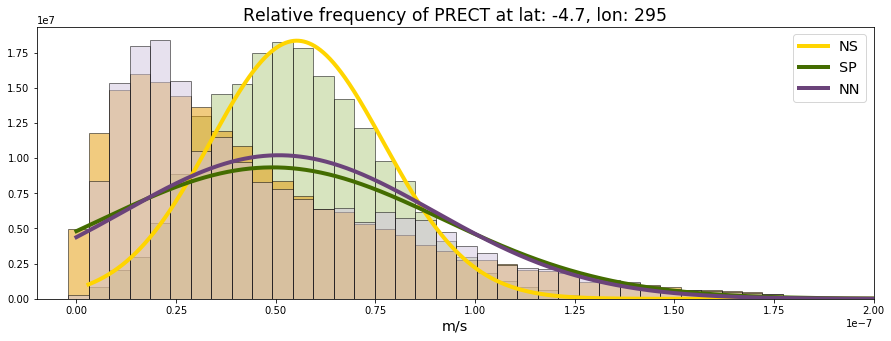

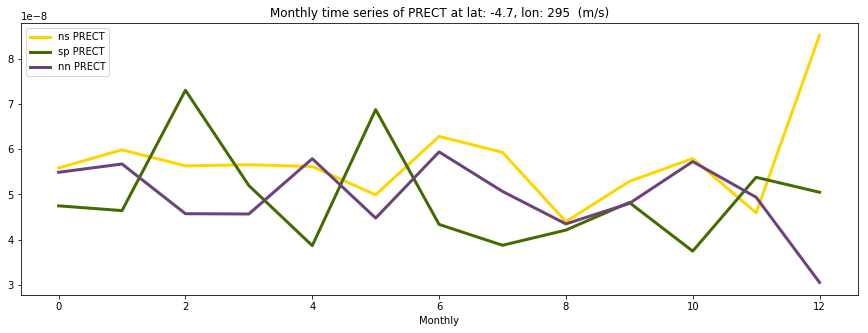

In [10]:
plothist(nsatm, spatm, nnatm, 'PRECT', xmin=-0.00000001, xmax=0.0000002)
plottimeseries(nsatm, spatm, nnatm, 'PRECT', groupby='M')

       datapoints           max          mean           min         std
nonsp       17569  99068.289062  98684.140625  98263.593750  119.461800
sp          17569  99220.500000  98768.867188  98155.078125  155.426071
nn          17568  99237.945312  98761.812500  98246.562500  159.310379


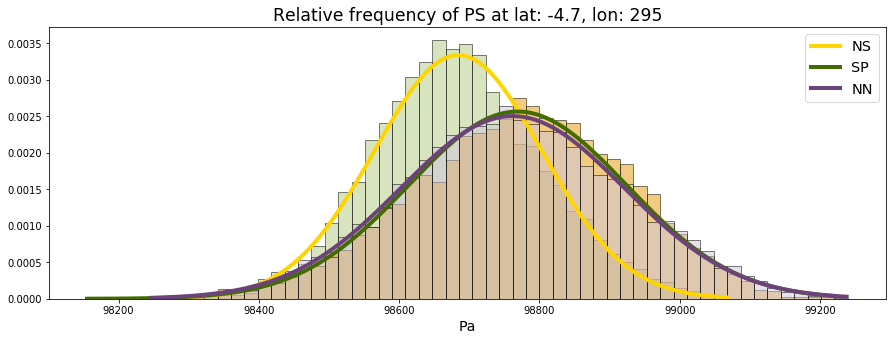

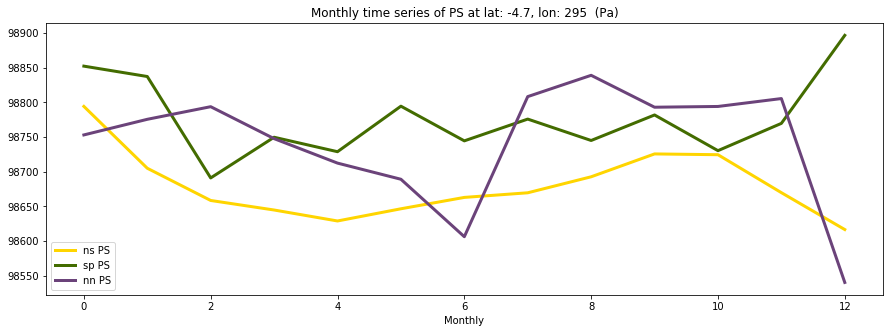

In [11]:
plothist(nsatm, spatm, nnatm, 'PS', rmnonpos=True)
plottimeseries(nsatm, spatm, nnatm, 'PS', groupby='M')

       datapoints       max      mean       min       std
nonsp       17569  0.017779  0.016256  0.014351  0.000504
sp          17569  0.019117  0.016785  0.014743  0.000740
nn          17568  0.019050  0.016906  0.014452  0.000750


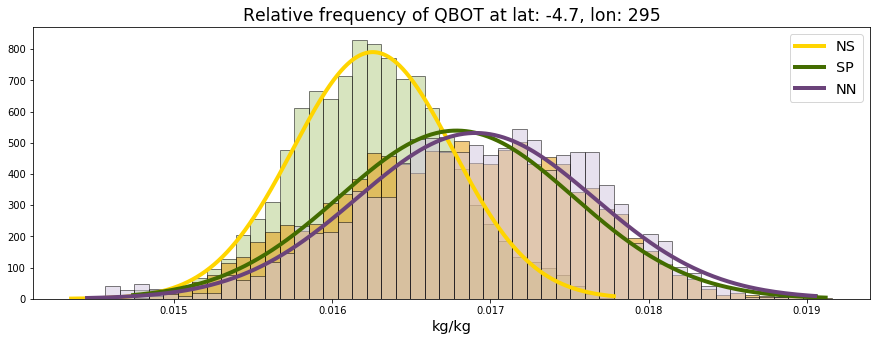

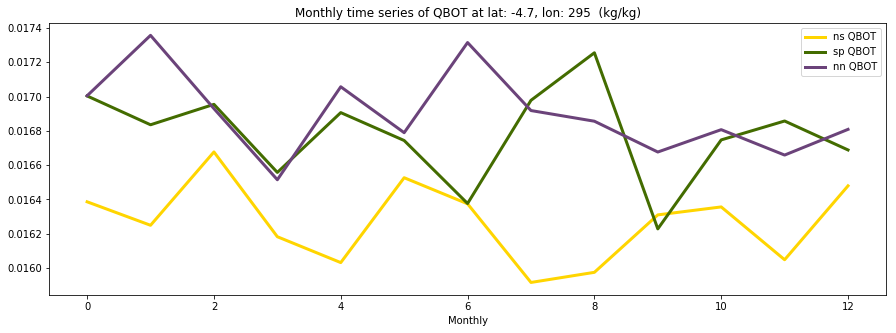

In [12]:
plothist(nsatm, spatm, nnatm, 'QBOT', rmnonpos=True)
plottimeseries(nsatm, spatm, nnatm, 'QBOT', groupby='M')

       datapoints         max        mean         min       std
nonsp       17569  298.833649  297.987885  296.703186  0.275324
sp          17569  299.577148  298.617065  297.493256  0.333720
nn          17569  299.398621  298.619415  297.635315  0.318283


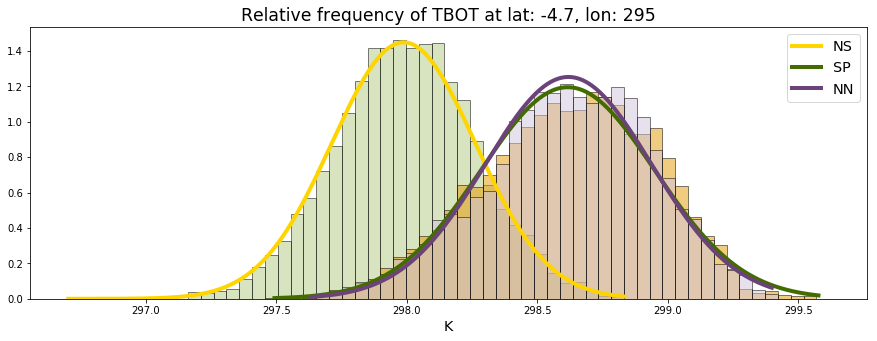

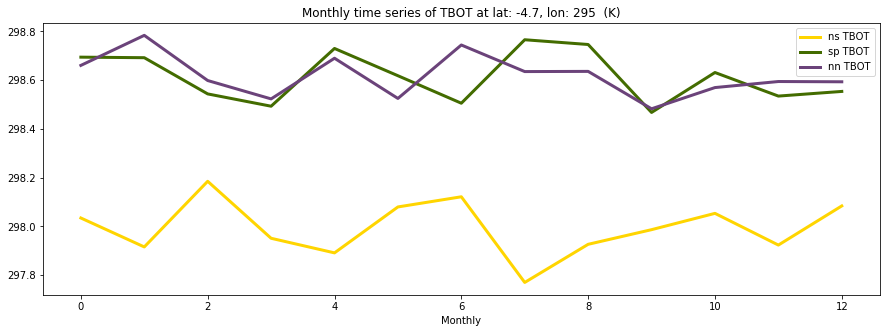

In [13]:
plothist(nsatm, spatm, nnatm, 'TBOT')
plottimeseries(nsatm, spatm, nnatm, 'TBOT', groupby='M')

       datapoints       max      mean        min       std
nonsp       17569  0.608603 -5.182385  -9.848533  1.714706
sp          17569  1.061987 -6.020444 -10.825747  1.966594
nn          17569  2.078111 -5.906708 -11.030540  2.126615


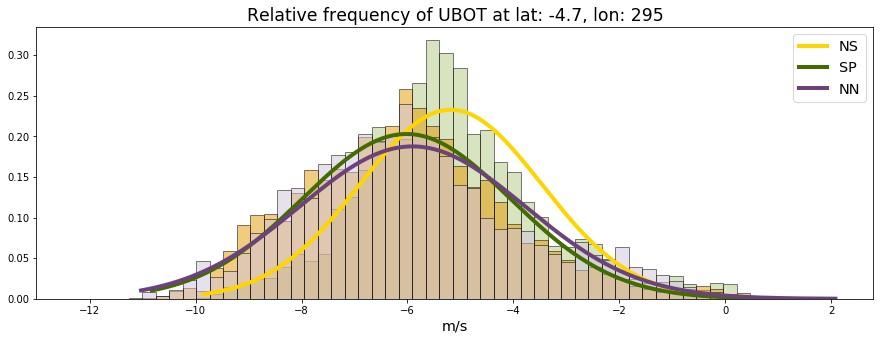

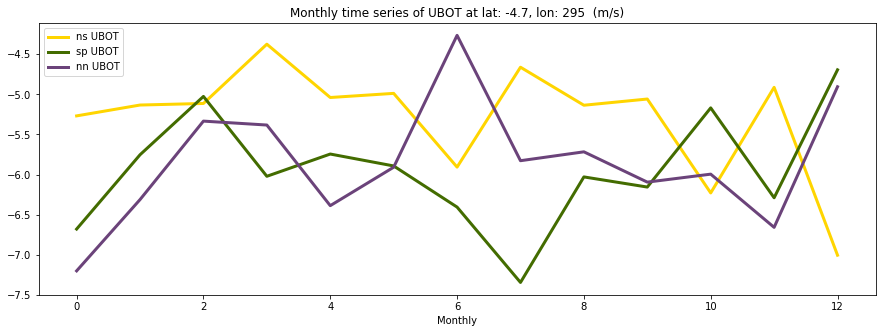

In [14]:
plothist(nsatm, spatm, nnatm, 'UBOT')
plottimeseries(nsatm, spatm, nnatm, 'UBOT', groupby='M')

       datapoints       max      mean       min       std
nonsp       17569  4.067626  0.126964 -3.355715  1.088404
sp          17569  5.659883  0.424049 -4.008984  1.421676
nn          17569  6.164823  0.304841 -3.723390  1.510348


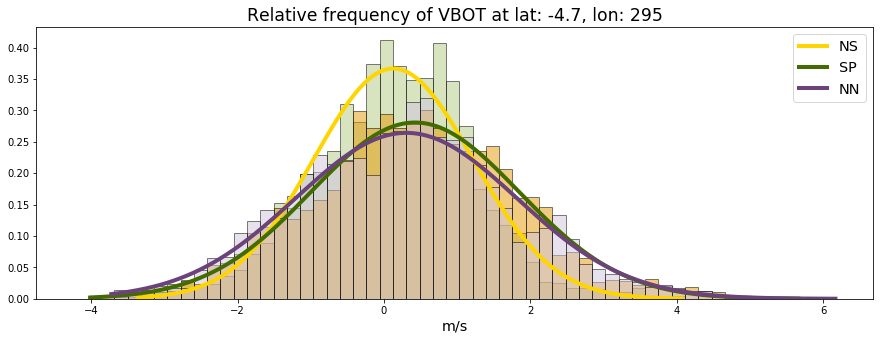

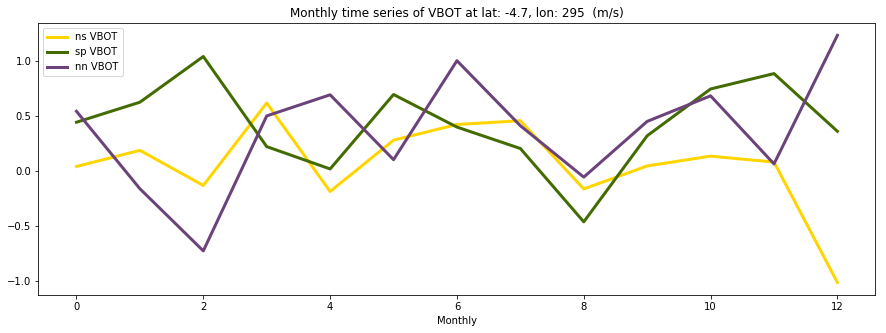

In [15]:
plothist(nsatm, spatm, nnatm, 'VBOT')
plottimeseries(nsatm, spatm, nnatm, 'VBOT', groupby='M')

####  Lnd hist and time series

       datapoints        max      mean        min        std
nonsp        5841  31.571293 -0.140017 -16.399710  11.875258
sp           5841  36.346752 -0.049378 -16.705919  12.400324
nn           5841  35.651882 -0.043019 -26.904608  12.849388


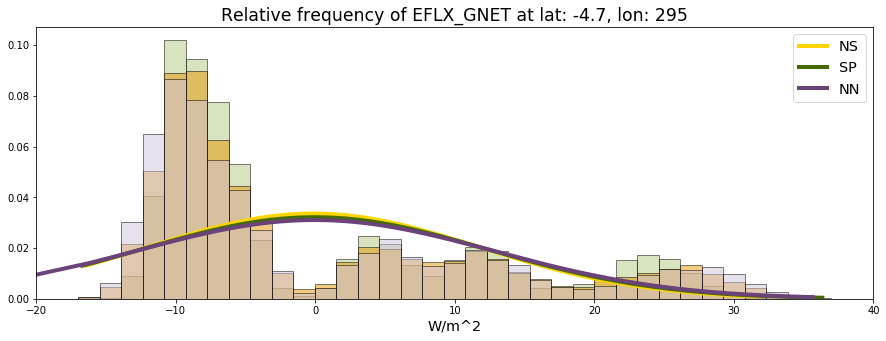

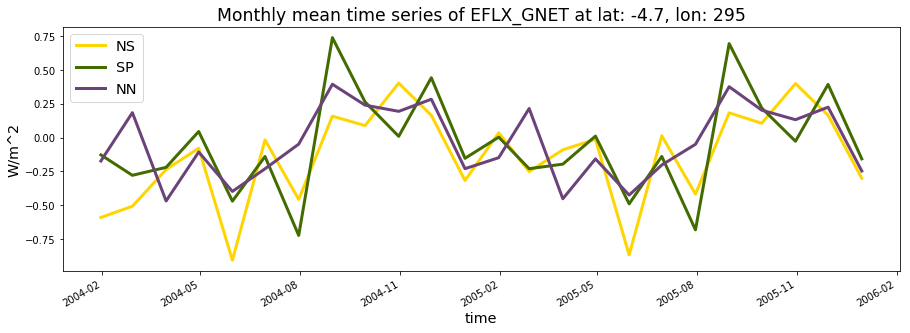

In [16]:
plothist(nslnd, splnd, nnlnd, 'EFLX_GNET', xmin=-20, xmax=40)
plotlndresample(nslnd, splnd, nnlnd, 'EFLX_GNET', 'M')

       datapoints         max        mean        min        std
nonsp        5841  388.728760  103.491539   7.502830  95.254974
sp           5841  394.319458  101.100281  10.106571  95.296547
nn           5841  401.309662  101.717377   8.450732  96.678444


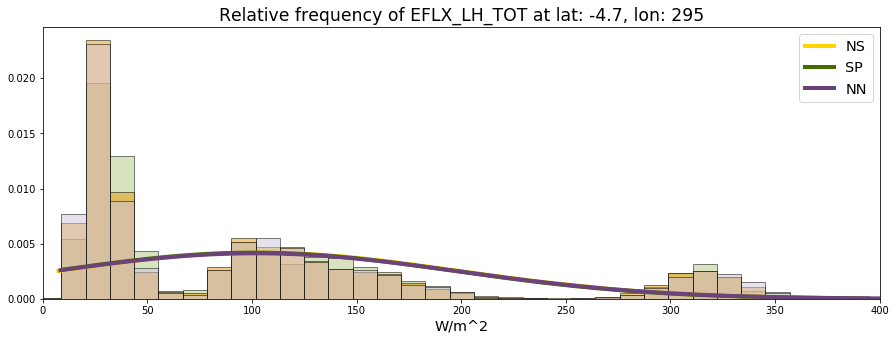

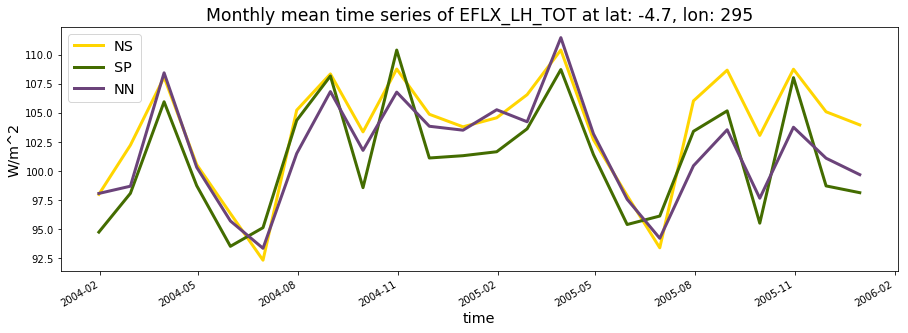

In [17]:
plothist(nslnd, splnd, nnlnd, 'EFLX_LH_TOT', xmin=0, xmax=400)
plotlndresample(nslnd, splnd, nnlnd, 'EFLX_LH_TOT', 'M')

       datapoints        max      mean        min        std
nonsp        5841  30.246782 -0.106274 -15.470058  11.080763
sp           5841  34.582756  0.028002 -15.315592  11.382050
nn           5841  33.665634  0.041795 -25.232426  11.776997


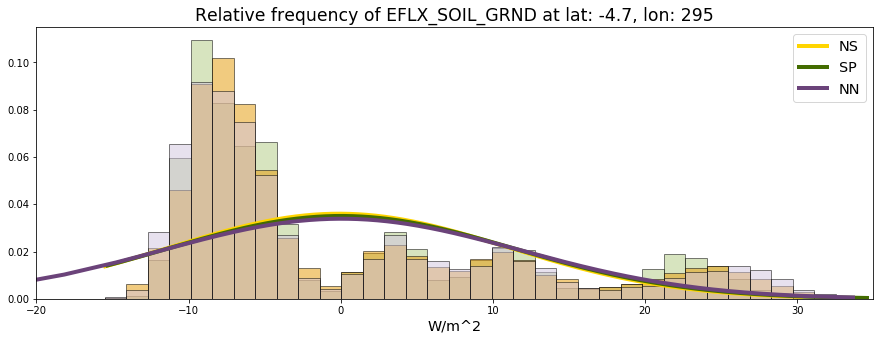

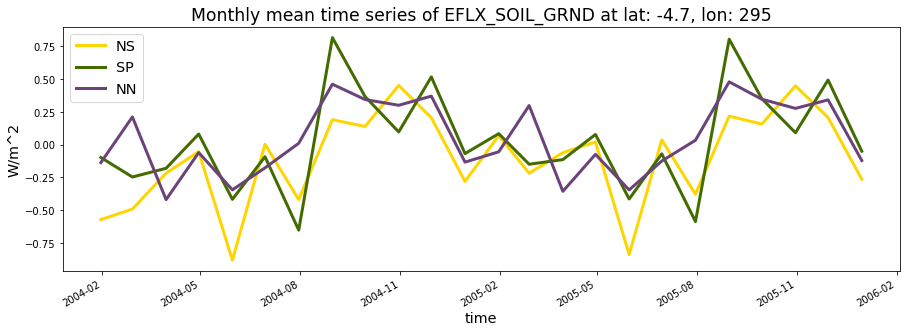

In [18]:
plothist(nslnd, splnd, nnlnd, 'EFLX_SOIL_GRND', xmin=-20, xmax=35)
plotlndresample(nslnd, splnd, nnlnd, 'EFLX_SOIL_GRND', 'M')

       datapoints       max      mean       min       std
nonsp        5841  0.000180  0.000123  0.000103  0.000019
sp           5841  0.000177  0.000115  0.000093  0.000017
nn           5841  0.000176  0.000115  0.000093  0.000017


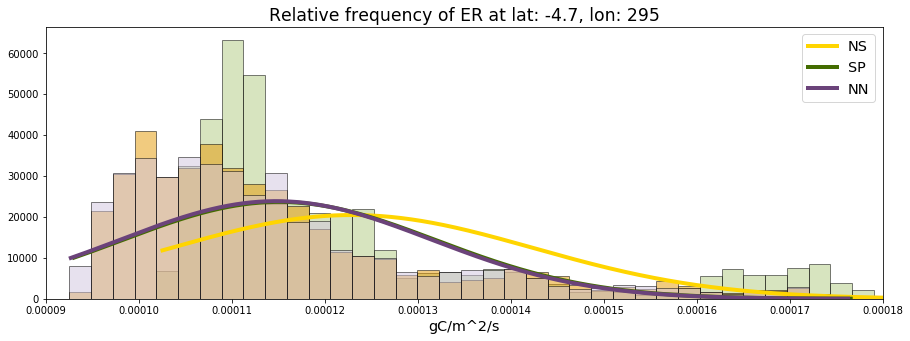

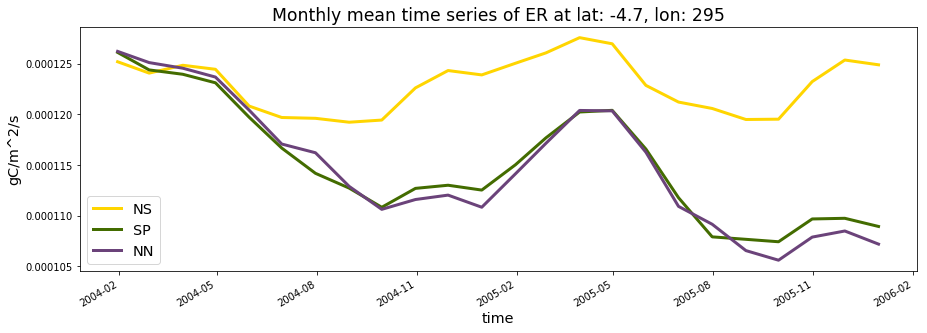

In [19]:
plothist(nslnd, splnd, nnlnd, 'ER', xmin=0.00009, xmax=0.00018)
plotlndresample(nslnd, splnd, nnlnd, 'ER', 'M')

       datapoints       max      mean  min       std
nonsp        5841  0.000432  0.000124  0.0  0.000140
sp           5841  0.000407  0.000115  0.0  0.000127
nn           5841  0.000412  0.000115  0.0  0.000126


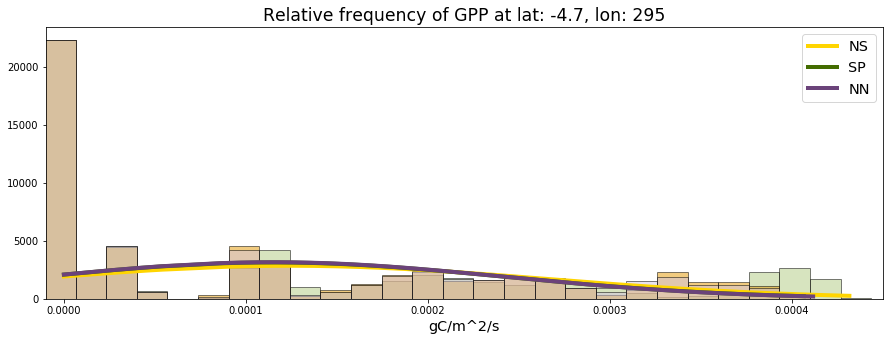

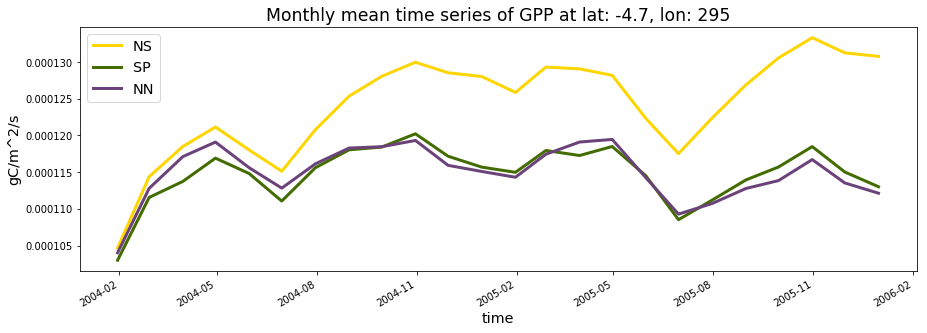

In [20]:
plothist(nslnd, splnd, nnlnd, 'GPP', xmin=-0.00001, xmax=0.00045)
plotlndresample(nslnd, splnd, nnlnd, 'GPP', 'M')

       datapoints       max      mean       min       std
nonsp        5841  3.730265  3.480476  3.207570  0.125308
sp           5841  3.730948  3.244624  2.887428  0.219147
nn           5841  3.707032  3.208002  2.833494  0.230569


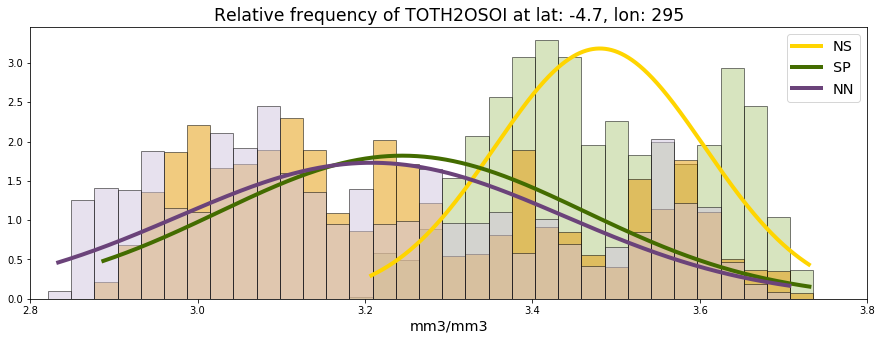

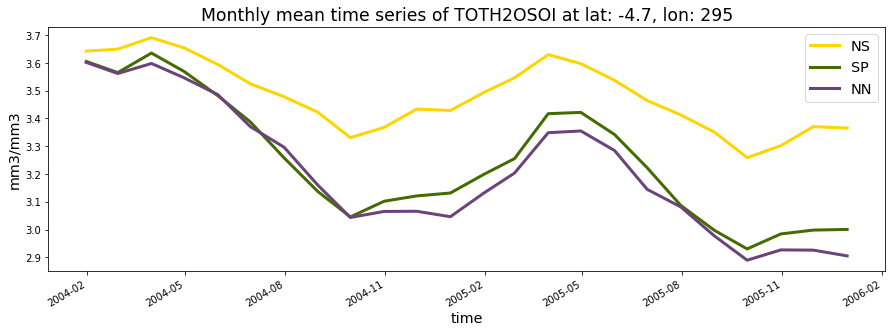

In [21]:
plothist(nslnd, splnd, nnlnd, 'TOTH2OSOI', xmin=2.8, xmax=3.8)
plotlndresample(nslnd, splnd, nnlnd, 'TOTH2OSOI', 'M')

       datapoints       max          mean       min       std
nonsp        5841  0.000251  1.958453e-07 -0.000122  0.000122
sp           5841  0.000234 -2.454602e-06 -0.000122  0.000113
nn           5841  0.000237 -2.179651e-06 -0.000122  0.000112


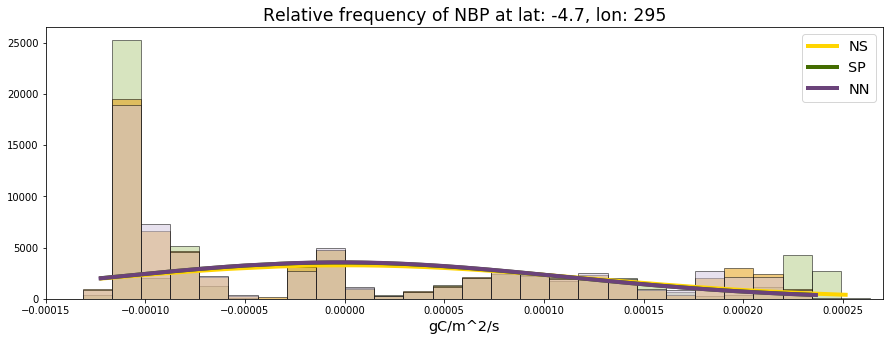

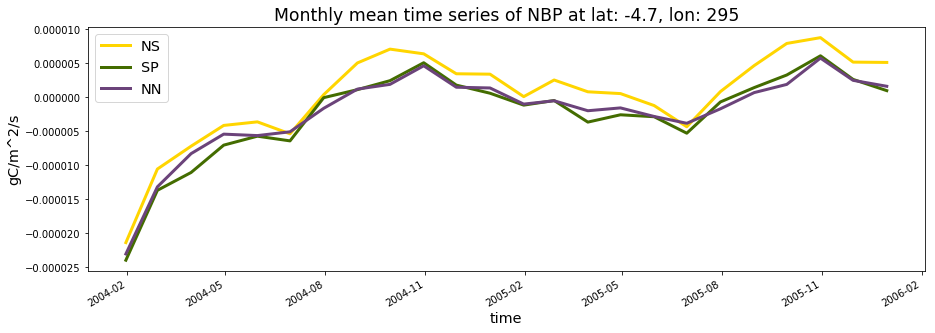

In [22]:
plothist(nslnd, splnd, nnlnd, 'NBP', xmin=-0.00015, xmax=0.00027)
plotlndresample(nslnd, splnd, nnlnd, 'NBP', 'M')

       datapoints       max      mean       min       std
nonsp        5841  0.000149  0.000038  0.000002  0.000038
sp           5841  0.000151  0.000036  0.000002  0.000038
nn           5841  0.000153  0.000036  0.000001  0.000038


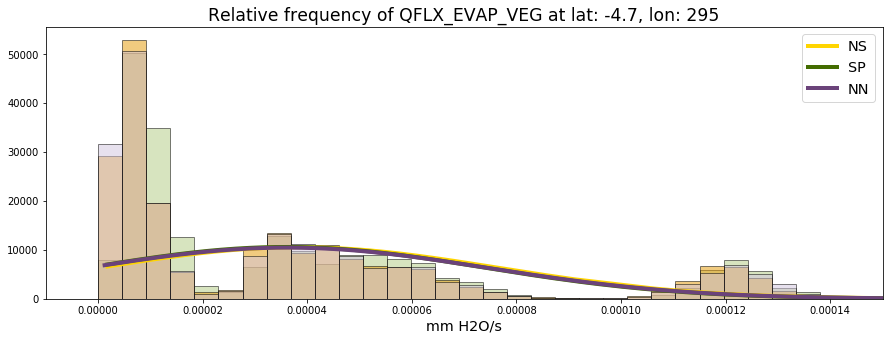

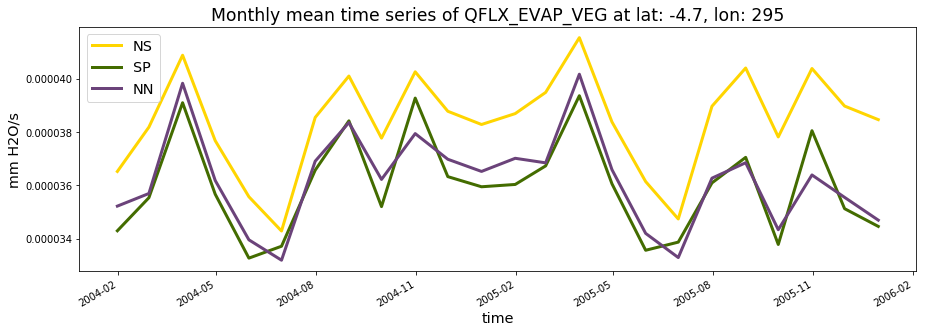

In [23]:
plothist(nslnd, splnd, nnlnd, 'QFLX_EVAP_VEG', xmin=-0.00001, xmax=0.00015)
plotlndresample(nslnd, splnd, nnlnd, 'QFLX_EVAP_VEG', 'M')

       datapoints       max      mean           min       std
nonsp        5841  0.000007  0.000003  7.121316e-07  0.000001
sp           5841  0.000010  0.000004  1.051069e-06  0.000001
nn           5841  0.000011  0.000004  1.165405e-06  0.000001


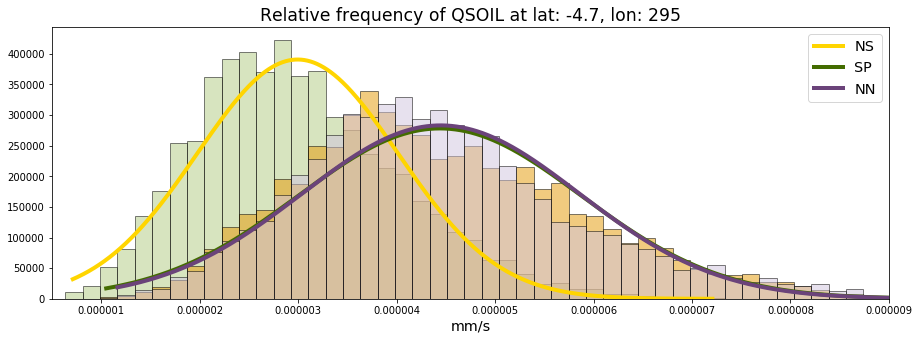

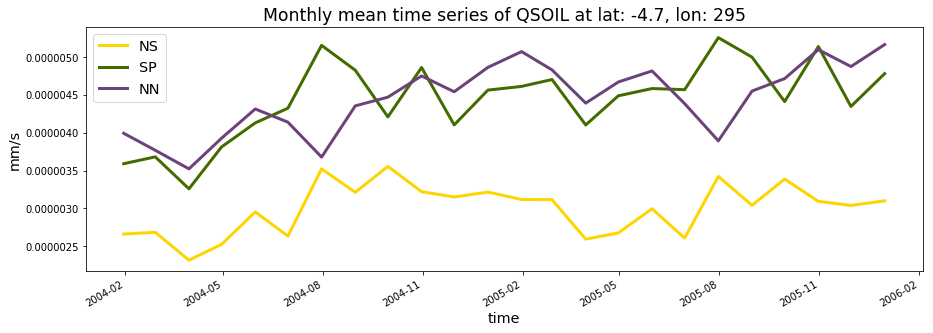

In [24]:
plothist(nslnd, splnd, nnlnd, 'QSOIL', xmin=0.0000005, xmax=0.000009)
plotlndresample(nslnd, splnd, nnlnd, 'QSOIL', 'M')

       datapoints       max      mean       min       std
nonsp        5841  9.541118  6.230756  6.003929  0.142135
sp           5841  9.541118  5.799984  5.607549  0.187861
nn           5841  9.541118  5.814680  5.566469  0.198058


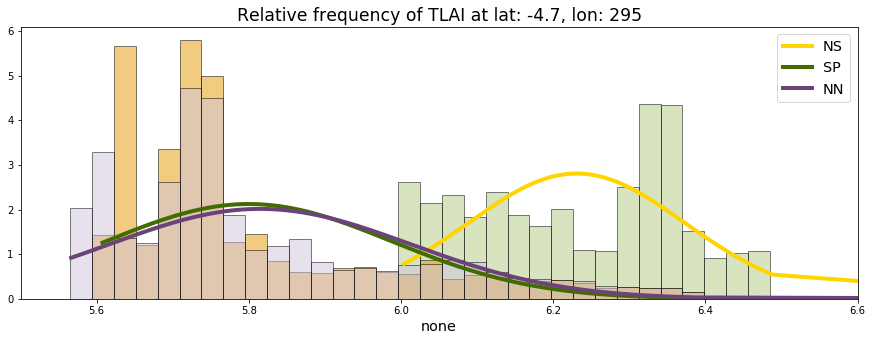

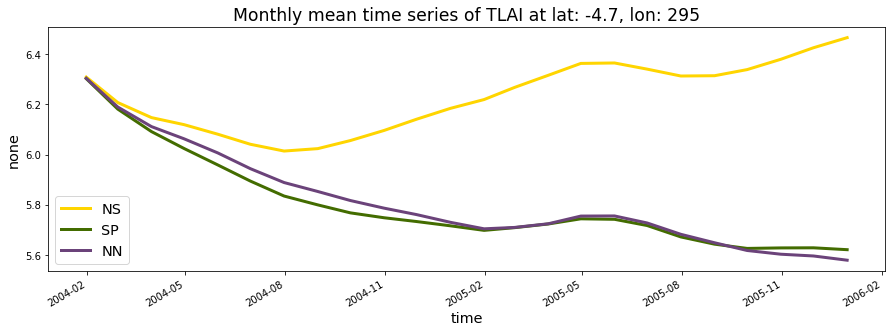

In [25]:
plothist(nslnd, splnd, nnlnd, 'TLAI', xmin=5.5, xmax=6.6)
plotlndresample(nslnd, splnd, nnlnd, 'TLAI', 'M')

       datapoints           max          mean           min        std
nonsp        5841  40133.039062  40049.914062  39988.367188  36.162594
sp           5841  40131.726562  39965.078125  39921.039062  44.014080
nn           5841  40131.726562  39979.531250  39942.265625  39.104237


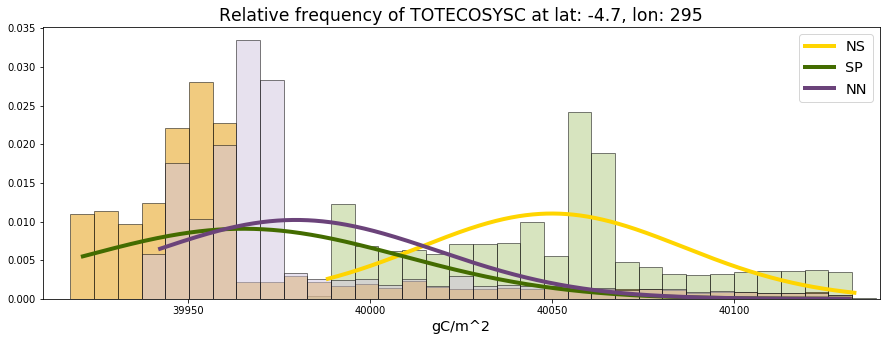

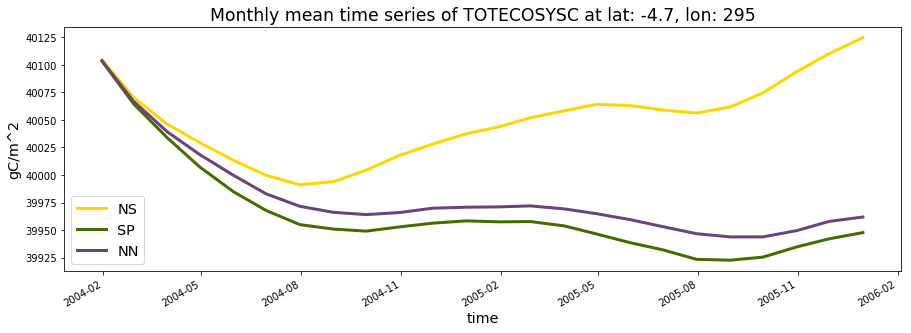

In [26]:
plothist(nslnd, splnd, nnlnd, 'TOTECOSYSC', xmin=39910, xmax=40140)
plotlndresample(nslnd, splnd, nnlnd, 'TOTECOSYSC', 'M')

       datapoints          max         mean          min         std
nonsp        5841  5722.911133  5429.393555  5178.254883  138.681229
sp           5841  5676.252930  5234.065918  4995.500488  184.202850
nn           5841  5617.755859  5204.658203  4953.288086  188.902435


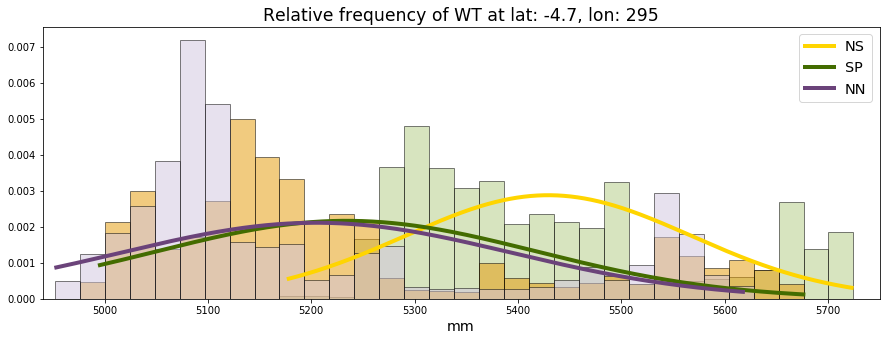

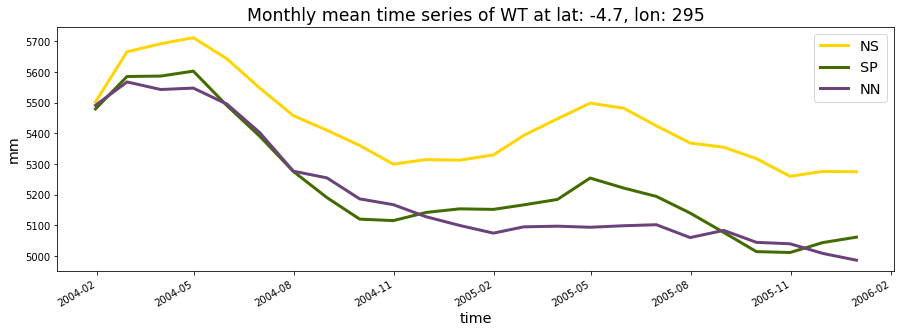

In [27]:
plothist(nslnd, splnd, nnlnd, 'WT', xmin=4940, xmax=5750)
plotlndresample(nslnd, splnd, nnlnd, 'WT', 'M')